In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

from sklearn.cluster import SpectralClustering, KMeans
from sklearn.datasets import make_moons, make_blobs
from sklearn.neighbors import kneighbors_graph
from scipy import sparse,linalg

import time

## Spectral Clustering

Celem projektu było napisanie skryptu do klasteryzacji spektralnej z wykorzystaniem CUDA

Sposób kompilacji: `nvcc spectralClustering.cu -o spectralClustering $(INC) $(NVCCFLAGS) $(LIB)`

- niezbędne biblioteki: libcudart i lcusolver
- flagi z jakimi należy uruchamiać program:
    - -f - ścieżka do pliku z danymi wejściowymi w formacie .csv (bez indeksów i nagłówków)
    - -o - ścieżka gdzie ma zostać zapisany plik .csv w którym zostanie umieszczony wynik programu
    - -k - liczba klastrów
    - -i - maksymalna ilość iteracji - dla algorytmu KMeans
    - -n - liczba najbliższych sąsiadów, używana podczas tworzenia Affinity Matrix

Implementacja programu w Cudzie zostało porównane z implementacją Spectral Clustering w scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) oraz własną implementacją tego algorytmu w Pythonie.

Zobrazowanie wyników można zobaczyć w dołączonym notebooku.

Średni czas wykonywania programu dla 10 powtórzeń:


|Problem| scikit-learn | Python | CUDA |
|--| -------- | -------- | -------- |
|1| 2.03     | 10.84   |   1.12  |
|2|3.42|21.73|1.43
|3|1.55|27.87|1.36
|4|0.41|10.27|0.43

W Spectral Clustering punkty danych traktuje się jako węzły grafu. W związku z tym, analiza skupień spektralnych jest problemem podziału grafu. Następnie węzły są mapowane na przestrzeń niskowymiarową, która może być łatwo podzielona na klastry. Nie zakłada się żadnego kształtu/formy klastrów. 

Spectral Clustering vs. KMeans
- Compactness — Punkty, które leżą blisko siebie, wpadają w ten sam klaster i są zwarte wokół centrum klastra. Bliskość można mierzyć przez odległość między obserwacjami. KMeans
- Connectivity — Punkty, które są połączone lub bezpośrednio obok siebie, są umieszczane w tym samym klastrze. Nawet jeśli odległość między dwoma punktami jest mała, jeśli nie są one połączone, nie są grupowane razem.

Algorytm:

- Rzutowanie danych na macierz Rn
- Konstrukcja Affinity Matrix, przy użyciu jądra Gaussa lub macierzy sąsiedztwa
- Konstrukcja Laplasjanu grafu z A 
- Obliczenie wartości oraz wektorów własnych macierzy
- Wybór k wektorów własnych odpowiadających k najniższym (lub najwyższym) wartościom własnym do zdefiniowania k-wymiarowej podprzestrzeni
- Obliczenie klastrów w tej podprzestrzeni przy użyciu KMeans

C:\Users\katar\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Elapsed time: 3.7673499584198 seconds


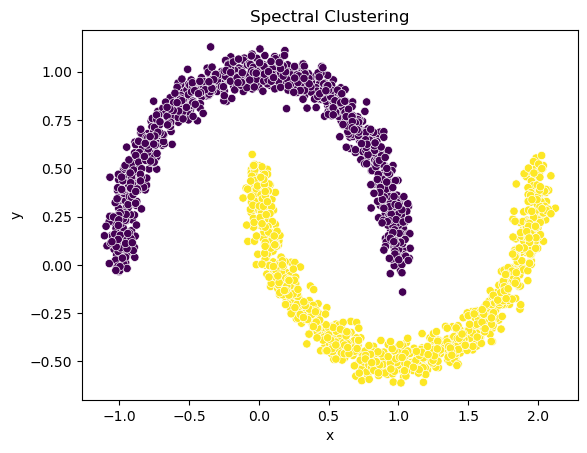

In [8]:
X, y = make_moons(n_samples=2000, noise=0.05, random_state=42)
data_df = pd.DataFrame(X, columns=['x', 'y'])

start_time = time.time()

sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
y_pred = sc.fit_predict(data_df.to_numpy())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

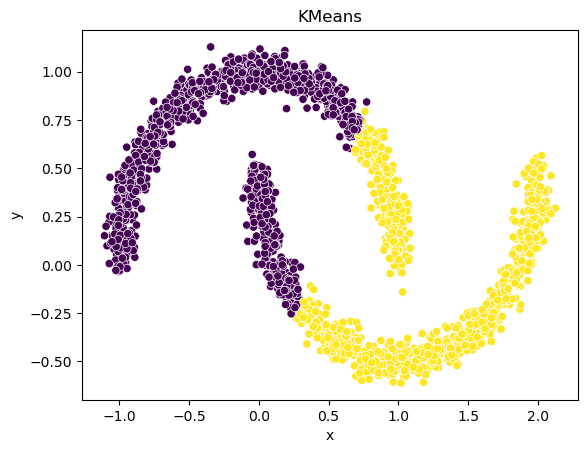

In [9]:
k_means = KMeans(random_state=25, n_clusters=2)
k_means.fit(data_df)
y_pred = k_means.predict(data_df)
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='KMeans');

In [4]:
def spectral_clustering(df, n_neighbors, n_clusters):
    connectivity = kneighbors_graph(X=df, n_neighbors=n_neighbors, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: n_clusters]
    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(proj_df)
    cluster = k_means.predict(proj_df)
    return cluster

Elapsed time: 7.740170478820801 seconds


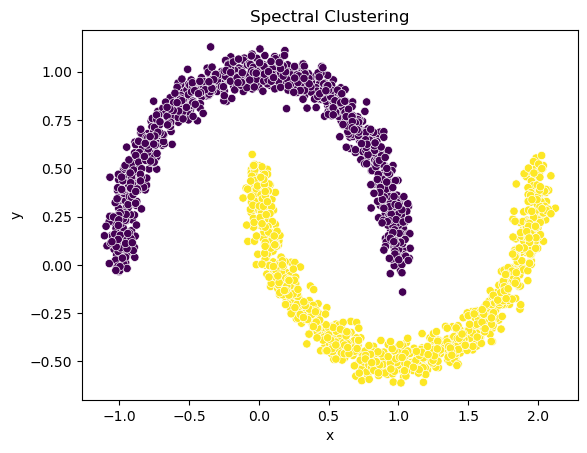

In [5]:
start_time = time.time()

y_pred = spectral_clustering(data_df, 8, 2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

In [10]:
csv_filename = 'input_data.csv'
data_df.to_csv(csv_filename, index=False, header=False)

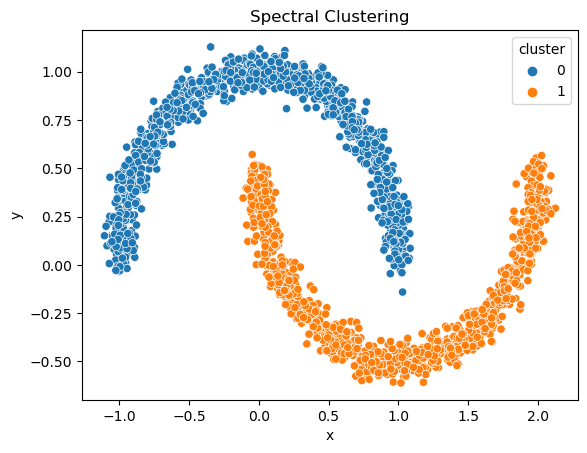

In [11]:
data_df['cluster'] = pd.read_csv("clustered_data.csv", header=None, names=['cluster'])
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

In [12]:
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    return x, y

def generate_concentric_circles_data(param_list):
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]
    return coordinates

In [13]:
n = 1000
r_list =[2, 4, 6]
sigmas = [0.1, 0.25, 0.5]
param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 
coordinates_list = []


for i, param_list in enumerate(param_lists):
    coordinates = generate_concentric_circles_data(param_list)
    coordinates_list.append(coordinates)

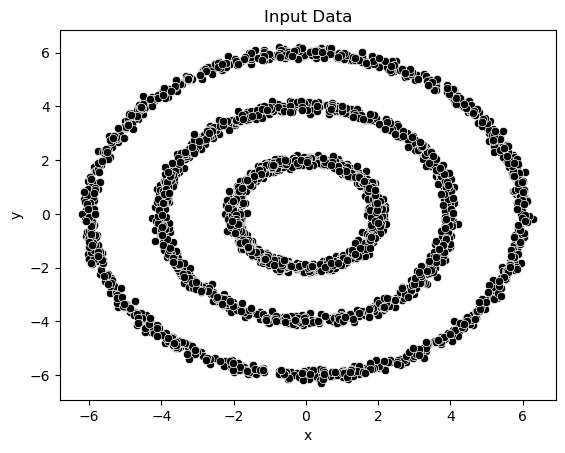

In [14]:
def data_frame_from_coordinates(coordinates): 
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates_list[0])

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

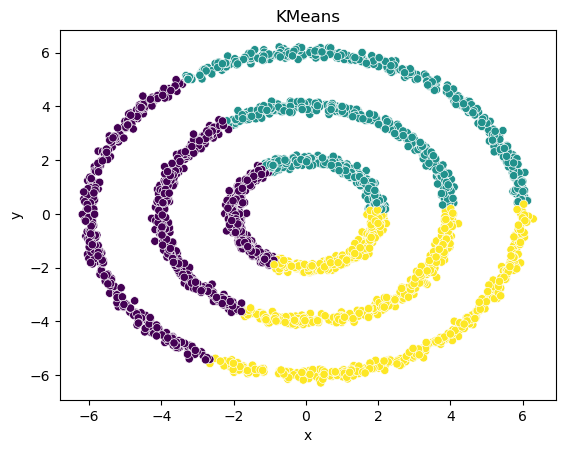

In [15]:
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df)
y_pred = k_means.predict(data_df)
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='KMeans');

C:\Users\katar\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Elapsed time: 5.144656658172607 seconds


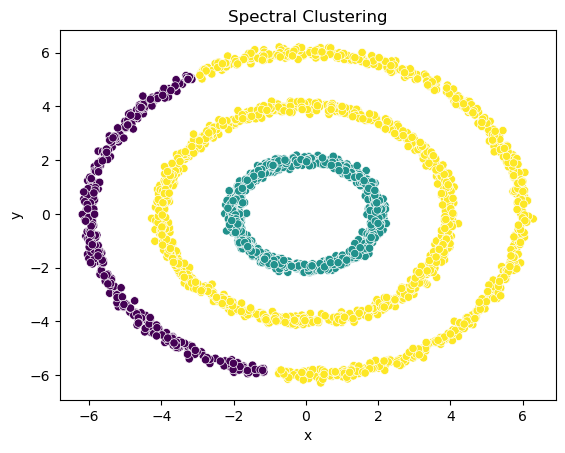

In [16]:
start_time = time.time()

sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors')
y_pred = sc.fit_predict(data_df.to_numpy())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

Elapsed time: 16.632153034210205 seconds


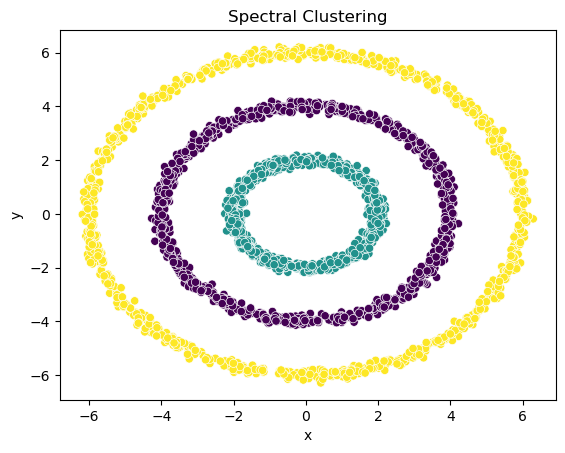

In [17]:
start_time = time.time()

y_pred = spectral_clustering(data_df, 8, 3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

In [18]:
csv_filename = 'input_data.csv'
data_df.to_csv(csv_filename, index=False)

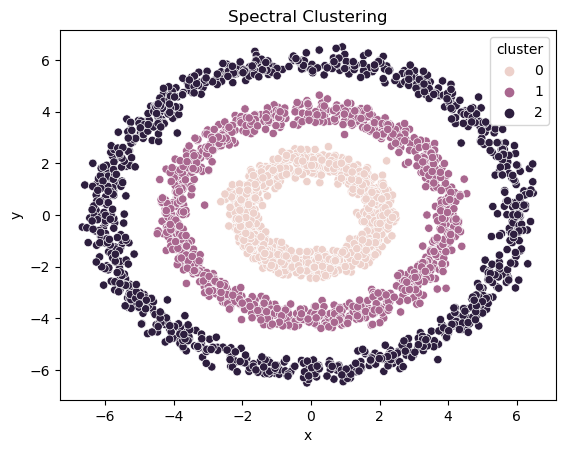

In [23]:
data_df['cluster'] = pd.read_csv("clustered_data.csv", header=None, names=['cluster'])
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

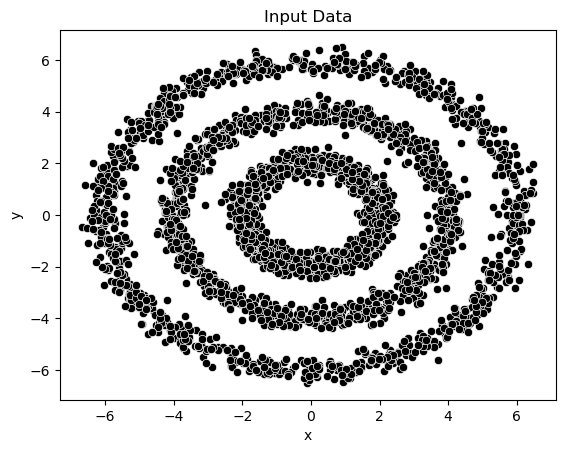

In [20]:
data_df = data_frame_from_coordinates(coordinates_list[1])

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

Elapsed time: 1.4981169700622559 seconds


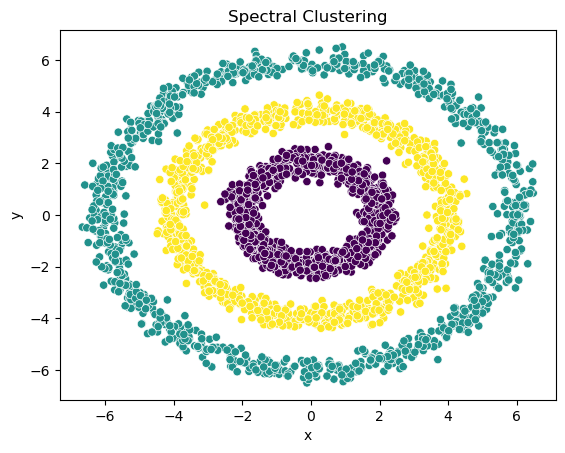

In [91]:
start_time = time.time()

sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors')
y_pred = sc.fit_predict(data_df.to_numpy())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

Elapsed time: 27.75892448425293 seconds


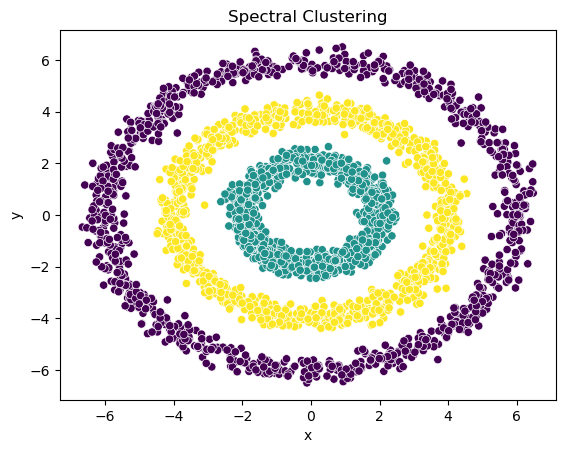

In [67]:
start_time = time.time()

y_pred = spectral_clustering(data_df, 8, 3)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, c=y_pred, ax=ax)
ax.set(title='Spectral Clustering');

In [21]:
csv_filename = 'input_data.csv'
data_df.to_csv(csv_filename, index=False)

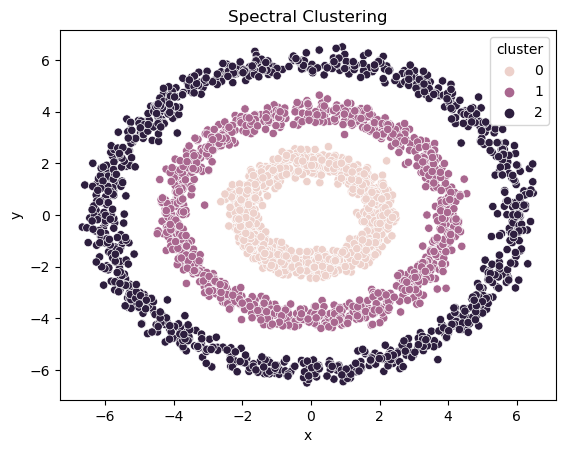

In [22]:
data_df['cluster'] = pd.read_csv("clustered_data.csv", header=None, names=['cluster'])
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

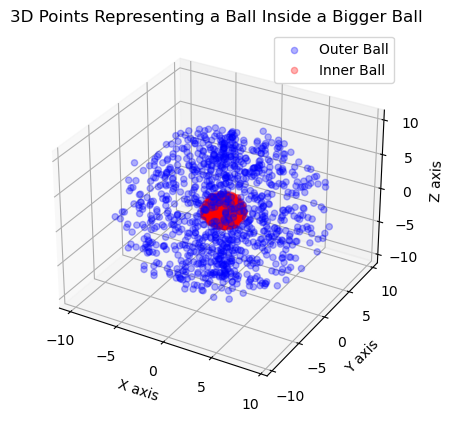

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


radius_inner = 2
radius_outer = 10
num_points = 1000


phi_outer = np.random.uniform(0, np.pi, num_points)
theta_outer = np.random.uniform(0, 2 * np.pi, num_points)
r_outer = radius_outer * np.cbrt(np.random.uniform(0, 1, num_points))

x_outer = r_outer * np.sin(phi_outer) * np.cos(theta_outer)
y_outer = r_outer * np.sin(phi_outer) * np.sin(theta_outer)
z_outer = r_outer * np.cos(phi_outer)


phi_inner = np.random.uniform(0, np.pi, num_points)
theta_inner = np.random.uniform(0, 2 * np.pi, num_points)
r_inner = radius_inner * np.cbrt(np.random.uniform(0, 1, num_points))

x_inner = r_inner * np.sin(phi_inner) * np.cos(theta_inner)
y_inner = r_inner * np.sin(phi_inner) * np.sin(theta_inner)
z_inner = r_inner * np.cos(phi_inner)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_outer, y_outer, z_outer, color='blue', alpha=0.3, label='Outer Ball')
ax.scatter(x_inner, y_inner, z_inner, color='red', alpha=0.3, label='Inner Ball')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Points Representing a Ball Inside a Bigger Ball')
ax.legend()
plt.show()

In [47]:
combined_x = np.concatenate((x_inner, x_outer))
combined_y = np.concatenate((y_inner, y_outer))
combined_z = np.concatenate((z_inner, z_outer))

data_df = pd.DataFrame({
    'x': combined_x,
    'y': combined_y,
    'z': combined_z
})

Elapsed time: 0.31261706352233887 seconds


Text(0.5, 0, 'Z Label')

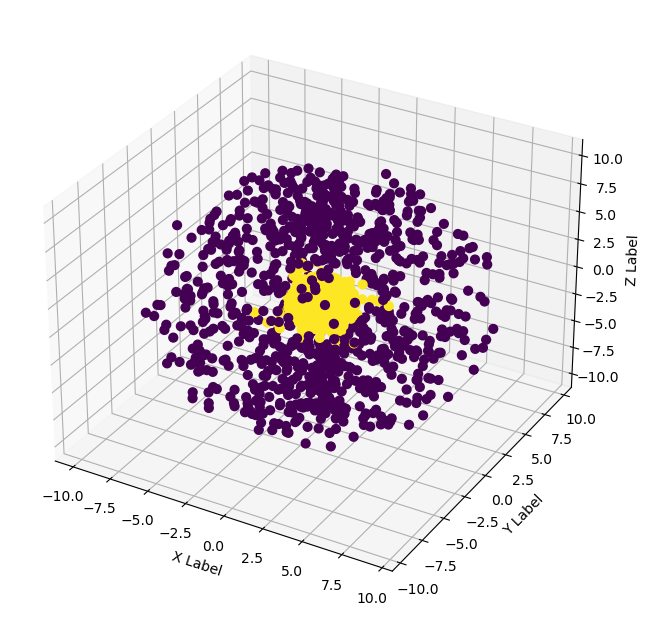

In [48]:
start_time = time.time()

sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
y_pred = sc.fit_predict(data_df.to_numpy())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(data_df['x'], data_df['y'], data_df['z'], s=40, c=y_pred, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Elapsed time: 9.64492130279541 seconds


Text(0.5, 0, 'Z Label')

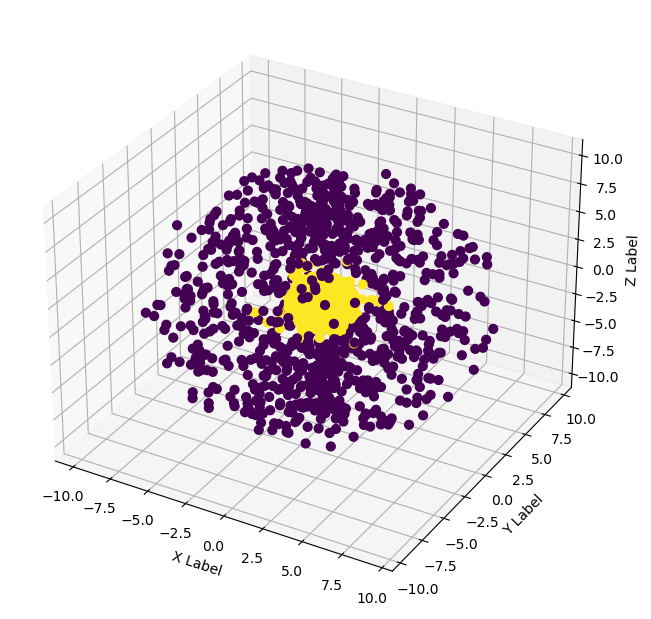

In [51]:
start_time = time.time()

y_pred = spectral_clustering(data_df, 8, 2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(data_df['x'], data_df['y'], data_df['z'], s=40, c=y_pred, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [49]:
csv_filename = 'input_data.csv'
data_df.to_csv(csv_filename, index=False)

Text(0.5, 0, 'Z Label')

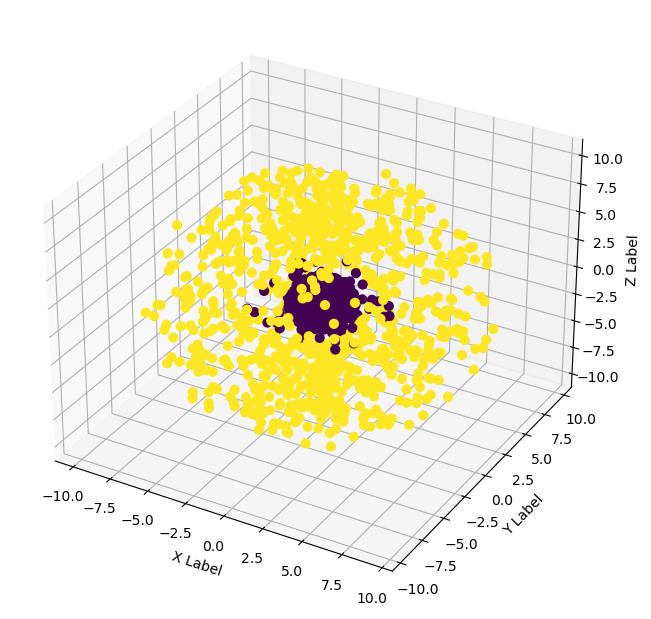

In [53]:
y_pred = pd.read_csv("clustered_data.csv", header=None, names=['cluster'])
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(data_df['x'], data_df['y'], data_df['z'], s=40, c=y_pred, marker='o', alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
